In [1]:
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
from sklearn.model_selection import train_test_split
from utils import *
import pandas as pd

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

In [4]:
all_data, all_words, all_tags = data

In [5]:
df = list_to_dataframe(data)

In [6]:
words = get_unique_words(df)
tags = get_unique_tags(df)
chars = set([w_i for w in words for w_i in w])

In [7]:
dt_pair = to_token_tag_list(data)

In [8]:
X_word, X_char, y, idx_word, idx_tag = input_data_wc_embd(words, tags, dt_pair)

In [9]:
X_word_train, X_word_test, y_train, y_test = train_test_split(X_word, y, test_size=0.33, random_state=1)
X_char_train, X_char_test, _, _ = train_test_split(X_char, y, test_size=0.33, random_state=1)

In [10]:
num_words = len(words)
num_tags = len(tags)
num_char = len(chars)
max_len = 100
max_len_char = 10
model = wc_blstm_model(num_words, num_tags, num_char, max_len, max_len_char)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 10)]    0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 time_distributed (TimeDistribu  (None, 100, 10, 10)  5570       ['input_2[0][0]']                
 ted)                                                                                             
                                                                                                  
 embedding (Embedding)          (None, 100, 50)      1344600     ['input_1[0][0]']            

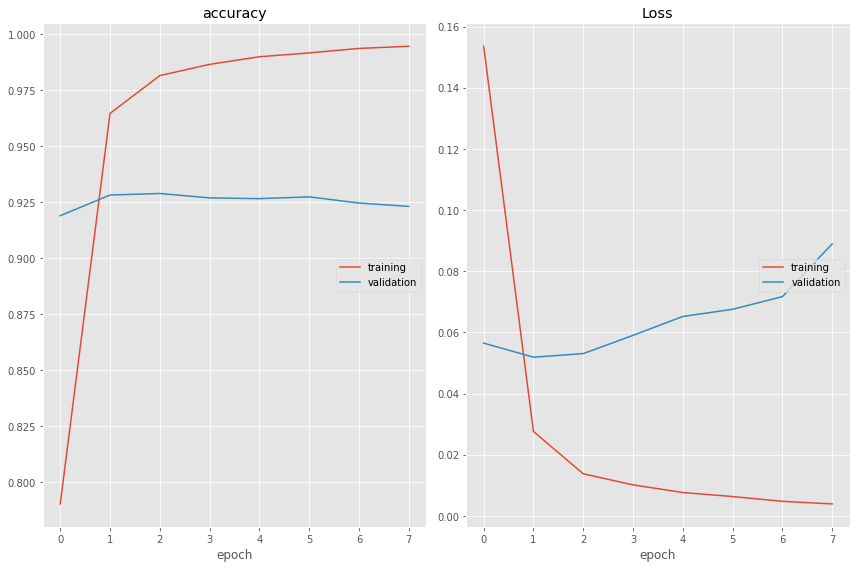

accuracy
	training         	 (min:    0.790, max:    0.995, cur:    0.995)
	validation       	 (min:    0.919, max:    0.929, cur:    0.923)
Loss
	training         	 (min:    0.004, max:    0.154, cur:    0.004)
	validation       	 (min:    0.052, max:    0.089, cur:    0.089)

Epoch 8: val_loss did not improve from 0.05188
102/102 [==============================] - 81s 793ms/step - loss: 0.0039 - accuracy: 0.9947 - val_loss: 0.0889 - val_accuracy: 0.9232


In [11]:
root_path = 'model/'
model_name = 'wc_blstm_model.h5'
wc_embd_model_fitting(model, root_path, model_name, X_word_train, X_char_train, y_train, num_epoch=50, batch_sz=32, max_len=max_len, max_len_char=max_len_char)

In [12]:
from keras.models import load_model

mdl = load_model('model/wc_blstm_model.h5')

In [13]:
i = np.random.randint(0, X_word_test.shape[0]) #659
p = mdl.predict([X_word_test,
                        np.array(X_char_test).reshape((len(X_char_test),
                                                     max_len, max_len_char))])
p = np.argmax(p[i], axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *60)

for w, true, pred in zip(X_word_test[i], y_true, p):
    if w != 0:
        print("{:30}{:10}\t{}".format(idx_word[w], idx_tag[true], idx_tag[pred]))

Word                          True      	 Pred

------------------------------------------------------------
alhamdulillah                 ID        	ID
ya                            ID        	ID
Allah                         O         	O
rezeki                        ID        	ID
dibulan                       ID        	ID
ramadhan                      O         	O
,                             O         	O
terima                        ID        	ID
kasih                         ID        	ID
banyak                        ID        	ID
buat                          ID        	ID
@christaline_                 O         	O
dan                           ID        	ID
sponsor                       ID        	ID
@AFTERDEATH_NFT               O         	O
dan                           ID        	ID
ga                            ID        	ID
lupa                          ID        	ID
juga                          ID        	ID
admin                         ID        	ID
@christagifts_  

In [14]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_word_test)):
    p = mdl.predict([X_word_test,
                        np.array(X_char_test).reshape((len(X_char_test),
                                                     max_len, max_len_char))])
    p = np.argmax(p[i], axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_word_test[i], y_true, p):
        if w != 0:
            # print("{:30}{:10}\t{}".format(idx_word[w], idx_tag[true], idx_tag[pred]))
            w_pair.append(idx_word[w])
            true_pair.append(idx_tag[true])
            pred_pair.append(idx_tag[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [15]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID       0.93      0.97      0.95     21898
          JV       0.87      0.87      0.87      4800
          EN       0.94      0.88      0.91      5388
   MIX-ID-EN       0.97      0.82      0.89       998
   MIX-ID-JV       0.99      0.78      0.88       305
   MIX-JV-EN       0.90      0.87      0.88       240
           O       0.95      0.91      0.93     10091

    accuracy                           0.93     43720
   macro avg       0.93      0.87      0.90     43720
weighted avg       0.93      0.93      0.93     43720



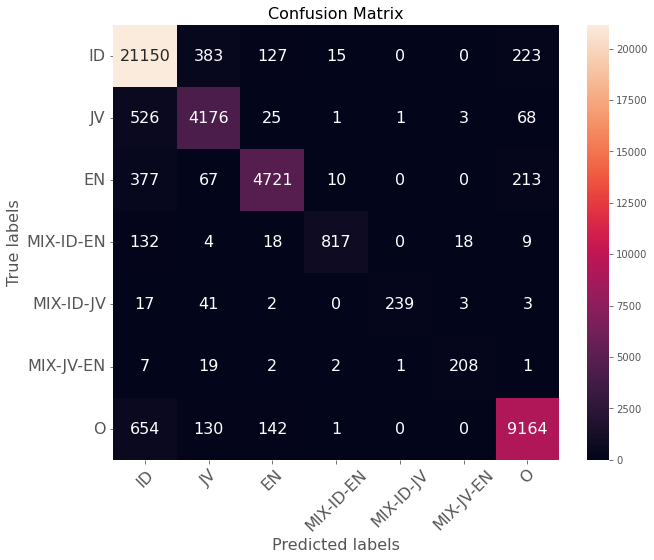

In [16]:
performance_report(true_flat, pred_flat)

In [17]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})

In [18]:
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)

In [19]:
true_pred_file = 'tagging_result/wc_blstm_compare_results.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")
    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()